In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import skforecast
import sklearn
from xgboost import XGBRegressor
from sklearn.feature_selection import RFECV
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
import warnings
warnings.filterwarnings('once')


In [4]:
data = pd.read_csv("datos_preprocesados.csv", parse_dates=['fecha'], index_col='fecha')
data = data.asfreq('D')

In [5]:
# Split train-validation-test
# ==============================================================================
end_train = '2021-12-31'
end_validation = '2023-08-12'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2019-01-01 00:00:00 --- 2021-12-31 00:00:00  (n=1096)
Dates validacion : 2021-12-31 00:00:00 --- 2023-08-12 00:00:00  (n=590)
Dates test       : 2023-08-12 00:00:00 --- 2024-09-26 00:00:00  (n=412)


In [6]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=15926),
                 lags      = 14
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_validation, 'demanda'])
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=15926, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for y: None 
Transformer for exog: None 
Window size: 14 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous v

In [7]:
# Backtest model on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data['demanda'],
                          steps              = 1,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(data[:end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = False, # Change to False to see less information
                          
                      )
#predictions.head()
print(metric)

  0%|          | 0/411 [00:00<?, ?it/s]

   mean_absolute_error
0           902.263105


In [8]:
exog_features = ['tmed', 'diasem', 'trim', 'hrmed', 'festivo']

# Backtesting model with exogenous variables on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data['demanda'],
    exog               = data[exog_features],
    steps              = 1,
    metric             = 'mean_absolute_error',
    initial_train_size = len(data[:end_validation]),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

print(metric)

  0%|          | 0/411 [00:00<?, ?it/s]

   mean_absolute_error
0           701.869213


In [9]:
# Create forecaster
forecaster = ForecasterAutoreg(
    regressor = XGBRegressor(random_state=15926),
    lags      = 14
)

# Lags grid
lags_grid = [7]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 200, 1000, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'subsample'       : trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        #He quitado lags
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = data.loc[:end_validation, 'demanda'],
    exog               = data.loc[:end_validation, exog_features],
    search_space       = search_space,
    steps              = 1,
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = len(data_train),
    fixed_train_size   = False,
    n_trials           = 10,
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
)
best_params = results_search['params'].iat[0]
best_lags = results_search['lags'].iat[0]


  0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'n_estimators': 700, 'max_depth': 8, 'learning_rate': 0.025967914628066663, 'subsample': 0.6349886915005383, 'colsample_bytree': 0.6011066731548598, 'gamma': 0.15895964414472274, 'reg_alpha': 0.1530705151247731, 'reg_lambda': 0.6955295287709109}
  Backtesting metric: 754.1338850275891



In [10]:
# Backtesting model with exogenous variables on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data['demanda'],
    exog               = data[exog_features],
    steps              = 1,
    metric             = 'mean_absolute_error',
    initial_train_size = len(data[:end_validation]),
    refit              = False,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
metric

  0%|          | 0/411 [00:00<?, ?it/s]

,mean_absolute_error
0,643.872095


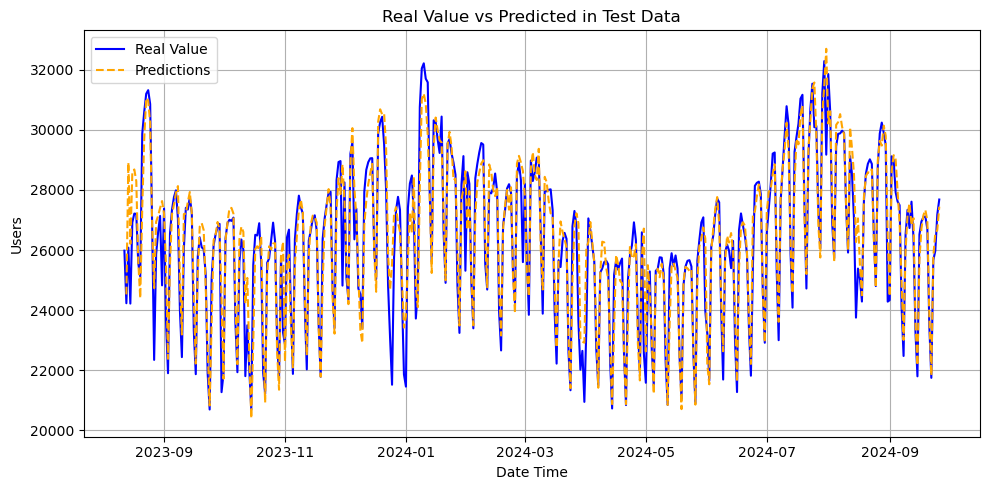

In [11]:
# Plot predictions vs real value
# ======================================================================================
plt.figure(figsize=(10, 5))  # Define el tamaño de la figura

# Graficar los valores reales
plt.plot(data_test.index, data_test['demanda'], label="Real Value", color='blue', linestyle='-')

# Graficar las predicciones
plt.plot(predictions.index, predictions['pred'], label="Predictions", color='orange', linestyle='--')

# Configurar el título y las etiquetas
plt.title("Real Value vs Predicted in Test Data")
plt.xlabel("Date Time")
plt.ylabel("Users")

# Añadir leyenda
plt.legend(loc='upper left')

# Mostrar el gráfico
plt.grid()  # Añadir cuadrícula para mejor visualización
plt.tight_layout()  # Ajustar el layout
plt.show()
